In [1]:
packages = !pip list
for x in packages:
    if "qiskit" in x:
        print(x)

qiskit                1.1.0
qiskit-aer            0.14.1
qiskit-ibm-provider   0.11.0
qiskit-ibm-runtime    0.24.0


In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

token = #putyour own token

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum",token=token)

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

In [3]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import *
from qiskit_aer import QasmSimulator
from qiskit.circuit.library import MCMT
from math import sqrt, pow, pi

In [4]:
#Create Diffuser circuit
def diffuser(nqubits):
    qc=QuantumCircuit(n)
    #diff=H^nR_oH^n
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    #Start implementing the R_0
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate using multicontrol multitarget gate MCMT
    cnz = MCMT('z', num_ctrl_qubits=nqubits-1, num_target_qubits=1)
    qc=qc.compose(cnz) #add cnz to the original qc
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    #apply xzxz to the first qubit
    qc.x(0)
    qc.z(0)

    qc.x(0)
    qc.z(0)
    # End of R_0
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [5]:
#Input the string size
n=6
#Create Oracle
qc = QuantumCircuit(n+1)
qc.cx(1,n)
qc.cx(0,n) #String is equal to 110000
#qc.cz(0, 3)
oracle_exn = qc.to_gate()
oracle_exn.name = "U$_\omega$"
grover_circuit = QuantumCircuit(n+1,n)
grover_circuit.x(n) #To create the Ancilla |->
for qubit in range(n+1):
    grover_circuit.h(qubit)

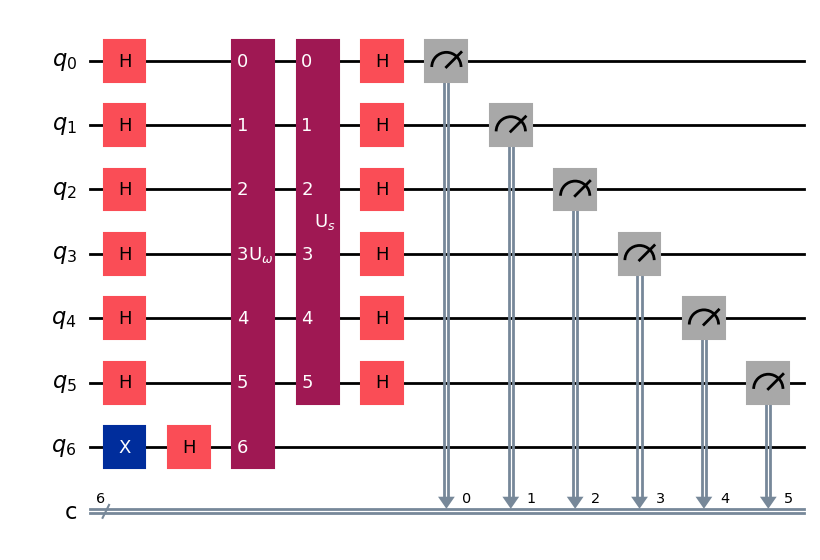

In [6]:
# Number of iterations of oracle and diffuser needed
t=pi*sqrt(pow(pow(2,n),0.5))/4-0.5
t=int(t)
#grover_circuit = initialize(grover_circuit, [0,1,2])
for i in range(t):
    grover_circuit=grover_circuit.compose(oracle_exn)
    grover_circuit=grover_circuit.compose(diffuser(n))
for qubit in range(n):
    grover_circuit.h(qubit)
for i in range(n):
    grover_circuit.measure(i,i)
#grover_circuit.measure_all()
grover_circuit.draw('mpl')

C:\Users\NFSBM\AppData\Local\Temp\ipykernel_20088\1385079427.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  results = aer_sim.run(qobj,shots=1000).result()


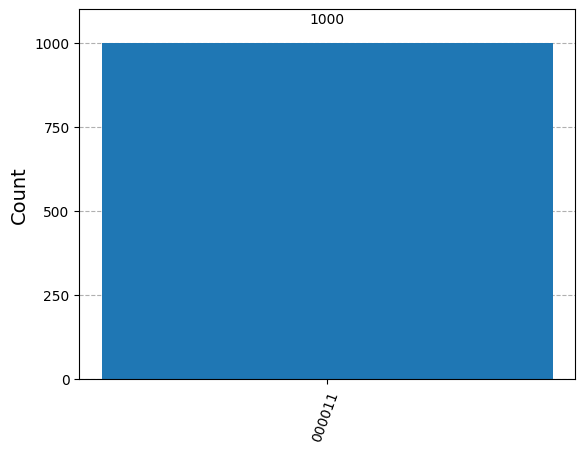

In [7]:
from qiskit_aer import Aer
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj,shots=1000).result()
counts = results.get_counts()
plot_histogram(counts)

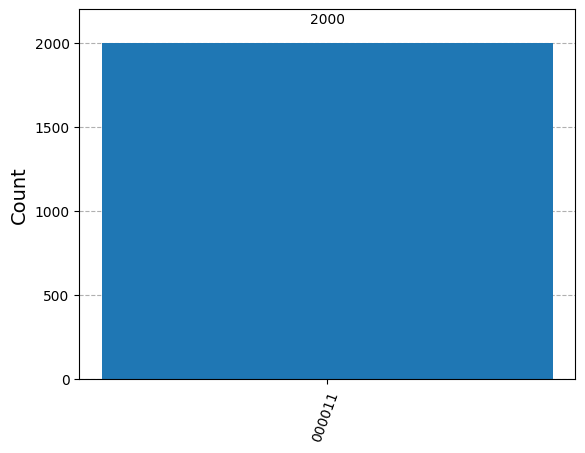

In [8]:
from qiskit_aer import Aer
backend = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit,backend,optimization_level=3)
job = backend.run(transpiled_grover_circuit,shots = 2000)
print(job)
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

C:\Users\NFSBM\AppData\Local\Temp\ipykernel_20088\606879312.py:6: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)


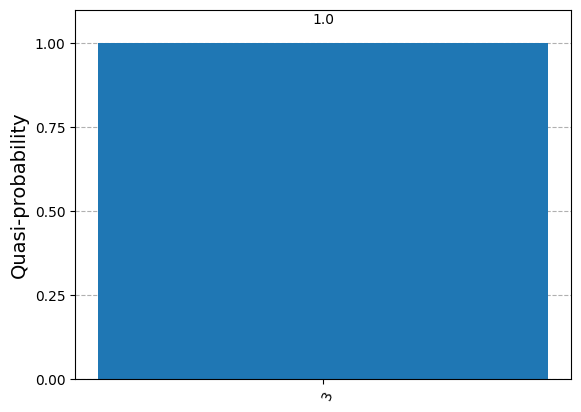

In [9]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import session
aer_sim = AerSimulator()
aer_sim.set_max_qubits(4)
with Session(backend=aer_sim) as session:
    sampler = Sampler(session=session)
    result = sampler.run([grover_circuit],optimization_level=3).result()
hist1 = plot_histogram(result.quasi_dists, sort='value_desc')
hist1

In [10]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account(token, overwrite=True)
provider = IBMProvider()
list = provider.backends()
print("backends available: ", list)

backends available:  [<IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_brisbane')>]


In [11]:
l = service.least_busy()

In [12]:
print(l.name)

ibm_kyoto


In [13]:
# backend = provider.get_backend('ibm_kyoto')
backend = provider.get_backend(l.name)
transpiled_grover_circuit = transpile(grover_circuit,backend,optimization_level=3)
job = backend.run(transpiled_grover_circuit,shots = 2000)
print(job)

<IBMCircuitJob('ct22q1m1k1wg008rt7zg')>


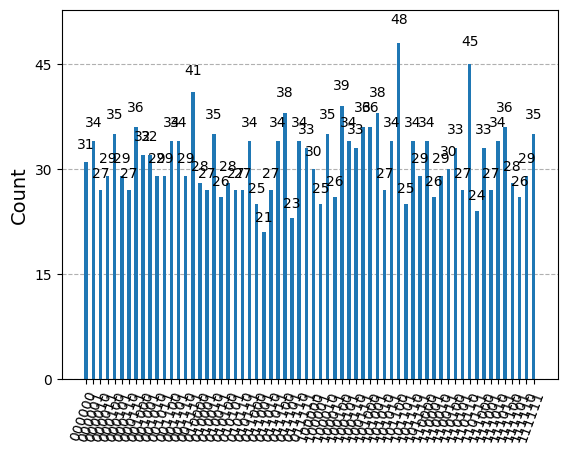

In [14]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)